In [1]:
# code adapted from https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33#:~:text=The%20Keras%20ResNet%20got%20to,to%20do%20with%20weight%20initializations.
# import plaidml
# import plaidml.keras
# plaidml.install_backend()
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
    
import random
random.seed(10)

from PIL import Image
from glob import glob

# Clean Script
from glob import glob
import tensorflow as tf
import os

from tensorflow.keras.utils import load_img

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model,load_model
from sklearn.model_selection import train_test_split

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# path_to_directory = 'imagedata/'


# Collect paths to images based on label
# The csv file is used so that there is no data leak depending on the machine
import pandas as pd
patientPaths = pd.read_csv('patientpaths.csv')['0'].to_list()
# patientPaths= glob(os.path.join(path_to_directory, "*", ""))

# print(patientPaths)
nonCancerTrPaths = []
nonCancerTestPaths = []
cancerousTrPaths = []
cancerousTestPaths = [] 
nonCancerValPaths1 = []
cancerousValPaths1 = []
nonCancerValPaths2 = []
cancerousValPaths2 = []

for i in range(0,168):
    nonCancerTrPaths.extend(glob(os.path.join(patientPaths[i], "0/", "*")))
    cancerousTrPaths.extend(glob(os.path.join(patientPaths[i], "1/", "*")))

for i in range(168, 196):
    nonCancerValPaths1.extend(glob(os.path.join(patientPaths[i], "0/", "*")))
    cancerousValPaths1.extend(glob(os.path.join(patientPaths[i], "1/", "*")))
    
for i in range(196, 224):
    nonCancerValPaths2.extend(glob(os.path.join(patientPaths[i], "0/", "*")))
    cancerousValPaths2.extend(glob(os.path.join(patientPaths[i], "1/", "*")))

for i in range(224,280):
    nonCancerTestPaths.extend(glob(os.path.join(patientPaths[i], "0/", "*")))
    cancerousTestPaths.extend(glob(os.path.join(patientPaths[i], "1/", "*")))


In [2]:
# Turn filepaths into image arrays to train a model
def paths_to_image(paths, label, num_samples):
    images = []
    labels = []
    for path in paths[0:num_samples]:
        image = load_img(path)
        image = image.resize([50, 50])
        imgArray = tf.keras.utils.img_to_array(image)
        images.append(imgArray)
        labels.append(label)
    return [images[0: num_samples], labels[0: num_samples]]

nonCancerTrImages = paths_to_image(nonCancerTrPaths, 0, len(nonCancerTrPaths))
cancerTrImages = paths_to_image(cancerousTrPaths, 1, len(cancerousTrPaths))

nonCancerValImages1 = paths_to_image(nonCancerValPaths1, 0, len(nonCancerValPaths1))
cancerValImages1 = paths_to_image(cancerousValPaths1, 1, len(cancerousValPaths1))

nonCancerValImages2 = paths_to_image(nonCancerValPaths2, 0, len(nonCancerValPaths2))
cancerValImages2 = paths_to_image(cancerousValPaths2, 1, len(cancerousValPaths2))

nonCancerTestImages = paths_to_image(nonCancerTestPaths, 0, len(nonCancerTestPaths))
cancerTestImages = paths_to_image(cancerousTestPaths, 1, len(cancerousTestPaths))


In [3]:
x_train = nonCancerTrImages[0] + cancerTrImages[0]
y_train = nonCancerTrImages[1] + cancerTrImages[1]

x_val1 = nonCancerValImages1[0] + cancerValImages1[0]
y_val1 = nonCancerValImages1[1] + cancerValImages1[1]

x_val2 = nonCancerValImages2[0] + cancerValImages2[0]
y_val2 = nonCancerValImages2[1] + cancerValImages2[1]

x_test = nonCancerTestImages[0]+ cancerTestImages[0]
y_test = nonCancerTestImages[1]+ cancerTestImages[1]

#function which rotates image a certain number of degrees = to rotation
def rotate_image(X, y, rotation, num_to_rotate = None):
    rotatedImages = []
    labels = []
    cancerX = X[y==1]
    if num_to_rotate is not None and num_to_rotate < len(cancerX):
        cancerX = cancerX[0: num_to_rotate]
    for img in cancerX:
        image = tf.keras.utils.array_to_img(img)
        image = image.resize([50, 50])
        rotateimg = image.rotate(rotation)
        imgArray = tf.keras.utils.img_to_array(rotateimg)
        rotatedImages.append(imgArray)
        labels.append(1)
    return [rotatedImages, labels]

train90 = rotate_image(np.array(cancerTrImages[0]), np.array(cancerTrImages[1]), 90, 25758)
train180 = rotate_image(np.array(cancerTrImages[0]), np.array(cancerTrImages[1]), 180, 25758)
train270 = rotate_image(np.array(cancerTrImages[0]), np.array(cancerTrImages[1]), 270, 25757)

print("Number of cancer images in training set", str((len(train180[0]) + len(train90[0])) + len(train270[0]) + len(cancerTrImages[0])))
print("Number of benign images in training set", str(len(nonCancerTrImages[0])))


Number of cancer images in training set 119604
Number of benign images in training set 119604


In [4]:
print("Number of cancer images in training set", str((len(train180[0]) + len(train90[0])) + len(train270[0]) + sum(y_train)))
print("Number of benign images in training set", str(len(y_train) - sum(y_train)))


Number of cancer images in training set 119604
Number of benign images in training set 119604


In [5]:
#combining training data with rotated data
x_train = np.array(x_train)
train90[0] = np.array(train90[0])
train180[0] = np.array(train180[0])
y_train = np.array(y_train)
train90[1] = np.array(train90[1])
train180[1] = np.array(train180[1])

training_x = np.concatenate((x_train, train90[0], train180[0],train270[0]), axis=0)
training_y = np.concatenate((y_train, train90[1], train180[1],train270[1]))


datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(training_x)

# Because of computing power problems we subset to 20000 images 
# (10000 cancerous and 10000 noncancerous) in training
# train_x_param = np.concatenate((training_x[0:5000] ,training_x[120000:125000]), axis=0)
# train_y_param = np.concatenate((training_y[0:5000] ,training_y[120000:125000]))

# train_param_iterator = datagen.flow(np.array(train_x_param), np.array(train_y_param))

val1_iterator = datagen.flow(np.array(x_val1), np.array(y_val1))
val1x_iterator = datagen.flow(np.array(x_val1),batch_size=32, shuffle=False)


In [6]:
# #Learning rates above .01 are not useful
import keras.backend as K
import tensorflow_addons as tfa
from keras.utils.np_utils import to_categorical  


# learning_rates = [.0001, .001, .01]
# batchsizes = [32, 256]
# mccs = []

# for lr in learning_rates:
#     for bs in batchsizes: 
#         model = VGG16(weights=None, include_top=True, input_shape= (50, 50,3), classes=2, classifier_activation='softmax')
#         adam = Adam(learning_rate=lr)
#         model.compile(optimizer= adam, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

#         print("FITTING")
#         history = model.fit(train_param_iterator, epochs=15, batch_size = bs, validation_data=val_iterator)
    
#         y_pred = model.predict(val1x_iterator)
#         print(y_pred)
#         y_true = to_categorical(np.array(y_val1), num_classes=2)
#         print(y_true)
#         metric = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
#         metric.update_state(y_true, y_pred)
#         result = metric.result()
#         result.numpy()
#         mccs.append((lr, bs, result.numpy()))

# The model outputs a value between 0 and 1, which can be thought of as a probability of being a cancer or not
# model.predict to find the pseudo probability which is a measure of confidence
# we can output the score and the prediction
# activation map to find the feature


# LR = .0001, BS = 256 achieves the highest validation MCC

In [7]:
# Include Val1 in our training set as we have validation 2 to tune our threshold
training_x = np.concatenate((training_x, np.array(x_val1)), axis=0)
training_y = np.concatenate((training_y, np.array(y_val1)))

print(training_x.shape)
print(training_y.shape)

(269019, 50, 50, 3)
(269019,)


FITTING
Epoch 1/15
8407/8407 [==============================] - 5872s 698ms/step - loss: 0.3117 - accuracy: 0.8642 - val_loss: 0.3799 - val_accuracy: 0.8335
Epoch 2/15
8407/8407 [==============================] - 5492s 653ms/step - loss: 0.2329 - accuracy: 0.9026 - val_loss: 0.3903 - val_accuracy: 0.8189
Epoch 3/15
8407/8407 [==============================] - 5587s 665ms/step - loss: 0.2129 - accuracy: 0.9107 - val_loss: 0.3611 - val_accuracy: 0.8409
Epoch 4/15
8407/8407 [==============================] - 5350s 636ms/step - loss: 0.2010 - accuracy: 0.9164 - val_loss: 0.3616 - val_accuracy: 0.8344
Epoch 5/15
8407/8407 [==============================] - 6040s 718ms/step - loss: 0.1895 - accuracy: 0.9212 - val_loss: 0.3403 - val_accuracy: 0.8520
Epoch 6/15
8407/8407 [==============================] - 6003s 714ms/step - loss: 0.1802 - accuracy: 0.9256 - val_loss: 0.3712 - val_accuracy: 0.8485
Epoch 7/15
8407/8407 [==============================] - 6176s 735ms/step - loss: 0.1723 - accuracy

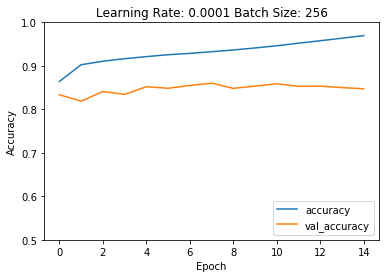

INFO:tensorflow:Assets written to: ThresholdTuning/assets


In [8]:
# Refit the normalization/standardization to the new training set
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(training_x)

train_iterator = datagen.flow(np.array(training_x), np.array(training_y))
val2_iterator = datagen.flow(np.array(x_val2), np.array(y_val2))

LR = .0001
BS = 256
model = VGG16(weights=None, include_top=True, input_shape= (50, 50,3), classes=2, classifier_activation='softmax')
adam = Adam(learning_rate=LR)
model.compile(optimizer= adam, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

print("FITTING")
history = model.fit(train_iterator, epochs=15, validation_data=val2_iterator, batch_size=BS)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Learning Rate: " + str(LR) + " Batch Size: " + str(BS))
plt.show()

model.save("ThresholdTuning")



In [54]:
def computeConfusionMatrix(preds, truth, threshold):
    TPs = np.sum(truth[preds> threshold])
    FPs = len(truth[preds > threshold]) - np.count_nonzero(truth[preds > threshold])
    TNs = len(truth[preds <= threshold]) - np.count_nonzero(y_val2[preds <= threshold])
    FNs = np.sum(truth[preds <= threshold])
    
    print("TP: " + str(TPs / np.sum(preds> threshold)))
    print("FP: " + str(FPs / np.sum(preds> threshold)))
    print("TN " + str(TNs / np.sum(preds<=threshold)))
    print("FN " + str(FNs / np.sum(preds<=threshold)))
    
    return None



In [19]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

val2_iterator = datagen.flow(np.array(x_val2), np.array(y_val2))
val2x_iterator = datagen.flow(np.array(x_val2), shuffle = False)

val2_preds = model.predict(val2x_iterator)


y_pred1 = [val2_preds[i][1] for i in range(0, val2_preds.shape[0])]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.array(y_val2), y_pred1)


auc_keras = auc(fpr_keras, tpr_keras)
plt.figure()

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("ROCThresholdTuner.png")

In [57]:
Ts = np.linspace(0, 1, num=1000)
ratio = 5
numBenignMisses = []
numCancerMisses = []

predictions = np.array(y_pred1)
y_val2 = np.array(y_val2)
for thresh in Ts:
    numBenignMiss = 0
    numCancerMiss = 0
    for i in range(0, len(predictions)):
        if (predictions[i] >= thresh) and (y_val2[i] == 0):
            numBenignMiss += 1
        if (predictions[i] < thresh) and (y_val2[i] == 1):
            numCancerMiss += 1
    numBenignMisses.append(numBenignMiss)
    numCancerMisses.append(numCancerMiss)

minDiff = 1000000000
Tstar = 0
for i in range(0, len(Ts)):
    diff = abs(numBenignMisses[i] - ratio*numCancerMisses[i])
    if diff < minDiff:
        minDiff = abs(numBenignMisses[i] - ratio*numCancerMisses[i])
        Tstar = Ts[i]

Tstar
computeConfusionMatrix(predictions, y_val2, Tstar)
            


TP: 0.623337308503807
FP: 0.376662691496193
TN 0.9427159462657478
FN 0.057284053734252105


In [55]:
# We can also find the optimal T for the posterior odds ratio using Bayesian detection theory
posteriorRatio = val2_preds[:, 1] / val2_preds[:, 0]

# The threshold is the ratio of the losses which is .1

np.sum(posteriorRatio > .1)
computeConfusionMatrix(posteriorRatio, y_val2, .1)

# Compute the confusion matrix 
TPs = np.sum(y_val2[posteriorRatio > .1])
FPs = len(y_val2[posteriorRatio > .1]) - np.count_nonzero(y_val2[posteriorRatio > .1])
TNs = len(y_val2[posteriorRatio <= .1]) - np.count_nonzero(y_val2[posteriorRatio <= .1])
FNs = np.sum(y_val2[posteriorRatio <= .1])

TPs, FPs, FNs, TNs

TP: 0.6772732061953429
FP: 0.322726793804657
TN 0.924573746593142
FN 0.07542625340685809


(6428, 3063, 1190, 14587)

## Rerun on full training dataset

In [ ]:
# fit model on full dataset 

from PIL import Image
from glob import glob

# Clean Script
from glob import glob
import tensorflow as tf
import os

from tensorflow.keras.utils import load_img

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model,load_model
from sklearn.model_selection import train_test_split

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# path_to_directory = 'imagedata/'


# Collect paths to images based on label
# The csv file is used so that there is no data leak depending on the machine
import pandas as pd
patientPaths = pd.read_csv('patientpaths.csv')['0'].to_list()
# patientPaths= glob(os.path.join(path_to_directory, "*", ""))

# print(patientPaths)
nonCancerTrPaths = []
nonCancerTestPaths = []
cancerousTrPaths = []
cancerousTestPaths = [] 
nonCancerValPaths1 = []
cancerousValPaths1 = []
nonCancerValPaths2 = []
cancerousValPaths2 = []

for i in range(0,224):
    nonCancerTrPaths.extend(glob(os.path.join(patientPaths[i], "0/", "*")))
    cancerousTrPaths.extend(glob(os.path.join(patientPaths[i], "1/", "*")))

for i in range(168, 196):
    nonCancerValPaths1.extend(glob(os.path.join(patientPaths[i], "0/", "*")))
    cancerousValPaths1.extend(glob(os.path.join(patientPaths[i], "1/", "*")))
    
for i in range(196, 224):
    nonCancerValPaths2.extend(glob(os.path.join(patientPaths[i], "0/", "*")))
    cancerousValPaths2.extend(glob(os.path.join(patientPaths[i], "1/", "*")))

for i in range(224,280):
    nonCancerTestPaths.extend(glob(os.path.join(patientPaths[i], "0/", "*")))
    cancerousTestPaths.extend(glob(os.path.join(patientPaths[i], "1/", "*")))

# Turn filepaths into image arrays to train a model
def paths_to_image(paths, label, num_samples):
    images = []
    labels = []
    for path in paths[0:num_samples]:
        image = load_img(path)
        image = image.resize([50, 50])
        imgArray = tf.keras.utils.img_to_array(image)
        images.append(imgArray)
        labels.append(label)
    return [images[0: num_samples], labels[0: num_samples]]

nonCancerTrImages = paths_to_image(nonCancerTrPaths, 0, len(nonCancerTrPaths))
cancerTrImages = paths_to_image(cancerousTrPaths, 1, len(cancerousTrPaths))

nonCancerValImages1 = paths_to_image(nonCancerValPaths1, 0, len(nonCancerValPaths1))
cancerValImages1 = paths_to_image(cancerousValPaths1, 1, len(cancerousValPaths1))

nonCancerValImages2 = paths_to_image(nonCancerValPaths2, 0, len(nonCancerValPaths2))
cancerValImages2 = paths_to_image(cancerousValPaths2, 1, len(cancerousValPaths2))

nonCancerTestImages = paths_to_image(nonCancerTestPaths, 0, len(nonCancerTestPaths))
cancerTestImages = paths_to_image(cancerousTestPaths, 1, len(cancerousTestPaths))

x_train = nonCancerTrImages[0] + cancerTrImages[0]
y_train = nonCancerTrImages[1] + cancerTrImages[1]

x_val1 = nonCancerValImages1[0] + cancerValImages1[0]
y_val1 = nonCancerValImages1[1] + cancerValImages1[1]

x_val2 = nonCancerValImages2[0] + cancerValImages2[0]
y_val2 = nonCancerValImages2[1] + cancerValImages2[1]

#function which rotates image a certain number of degrees = to rotation
def rotate_image(X, y, rotation, num_to_rotate = None):
    rotatedImages = []
    labels = []
    cancerX = X[y==1]
    if num_to_rotate is not None and num_to_rotate < len(cancerX):
        cancerX = cancerX[0: num_to_rotate]
    for img in cancerX:
        image = tf.keras.utils.array_to_img(img)
        image = image.resize([50, 50])
        rotateimg = image.rotate(rotation)
        imgArray = tf.keras.utils.img_to_array(rotateimg)
        rotatedImages.append(imgArray)
        labels.append(1)
    return [rotatedImages, labels]

train90 = rotate_image(np.array(cancerTrImages[0]), np.array(cancerTrImages[1]), 90, 25758)
train180 = rotate_image(np.array(cancerTrImages[0]), np.array(cancerTrImages[1]), 180, 25758)
train270 = rotate_image(np.array(cancerTrImages[0]), np.array(cancerTrImages[1]), 270, 25757)

val1aug90 = rotate_image(np.array(cancerValImages1[0]), np.array(cancerValImages1[1]), 90)
val1aug180 = rotate_image(np.array(cancerValImages1[0]), np.array(cancerValImages1[1]), 90, 4776)
val2aug90 = rotate_image(np.array(cancerValImages2[0]), np.array(cancerValImages2[1]), 90)
val2aug180 = rotate_image(np.array(cancerValImages2[0]), np.array(cancerValImages2[1]), 90, 2414)

print("Number of cancer images in training set", str((len(train180[0]) + len(train90[0])) + len(train270[0]) + len(cancerTrImages[0])))
print("Number of benign images in training set", str(len(nonCancerTrImages[0])))

print('cancer val images',len(cancerValImages1[0]))
print('noncancer val images',len(nonCancerValImages1[0]))
print('cancer val images',len(cancerValImages2[0]))
print('noncancer val images',len(nonCancerValImages2[0]))



In [ ]:
#combining training data with rotated data
x_train = np.array(x_train)
train90[0] = np.array(train90[0])
train180[0] = np.array(train180[0])
y_train = np.array(y_train)
train90[1] = np.array(train90[1])
train180[1] = np.array(train180[1])

training_x = np.concatenate((x_train, train90[0], train180[0],train270[0],x_val1,val1aug90[0],val1aug180[0],val2aug90[0],val2aug180[0]), axis=0)
training_y = np.concatenate((y_train, train90[1], train180[1],train270[1],y_val1,val1aug90[1],val1aug180[1],val2aug90[1],val2aug180[1]))

print(training_x.shape)
print(training_y.shape)




In [ ]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(training_x)

# Because of computing power problems we subset to 20000 images 
# (10000 cancerous and 10000 noncancerous) in training
# train_x_param = np.concatenate((training_x[0:5000] ,training_x[120000:125000]), axis=0)
# train_y_param = np.concatenate((training_y[0:5000] ,training_y[120000:125000]))

# train_param_iterator = datagen.flow(np.array(train_x_param), np.array(train_y_param))

val1_iterator = datagen.flow(np.array(x_val1), np.array(y_val1))
val1x_iterator = datagen.flow(np.array(x_val1),batch_size=32, shuffle=False)

# Refit the normalization/standardization to the new training set
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(training_x)

train_iterator = datagen.flow(np.array(training_x), np.array(training_y))
val2_iterator = datagen.flow(np.array(x_val2), np.array(y_val2))

LR = .0001
BS = 256
model = VGG16(weights=None, include_top=True, input_shape= (50, 50,3), classes=2, classifier_activation='softmax')
adam = Adam(learning_rate=LR)
model.compile(optimizer= adam, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

print("FITTING")
history = model.fit(train_iterator, epochs=15, validation_data=val2_iterator, batch_size=BS)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Learning Rate: " + str(LR) + " Batch Size: " + str(BS))
plt.show()

model.save("ThresholdTuning")

## Performance on Test Set

In [ ]:
model.summary()

In [ ]:
test_iterator = datagen.flow(np.array(x_test), np.array(y_test))

model.evaluate(test_iterator)

In [ ]:
a = np.array(y_test)
a[a==1].shape
 

acc = (49684*0.4283320903778076+0.8424640893936157*19697) /(49684+19697)
acc

In [ ]:
y_prediction = model.predict(np.array(x_test))
# ypred2 = model.predict_classes(np.array(x_test))


In [ ]:
prediction = np.zeros(y_prediction.shape[0])
mask = (y_prediction[:,0]<0.5)
prediction[mask] = 1
print(prediction)

equal = np.zeros(y_prediction.shape[0])
equal[prediction == np.array(y_test)] = 1

accuracy = np.sum(equal)/y_prediction.shape[0]
accuracy

In [ ]:
y_test[np.array(y_test) == 0]

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
result = confusion_matrix(y_test, prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result )

disp.plot()


In [ ]:
prediction = np.zeros(y_prediction.shape[0])
mask = (y_prediction[:,1]<0.8)
prediction[mask] = 1
print(prediction)

equal = np.zeros(y_prediction.shape[0])
equal[prediction == np.array(y_test)] = 1

accuracy = np.sum(equal)/y_prediction.shape[0]
accuracy

result = confusion_matrix(y_test, prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result )

disp.plot()

In [ ]:
# cancer evaluation
cancer_iterator = datagen.flow(np.array(np.array(x_test)[np.array(y_test) == 1]), np.array(y_test)[np.array(y_test) == 1])

model.evaluate(cancer_iterator)

In [ ]:
# benign evaluation

benign_iterator = datagen.flow(np.array(np.array(x_test)[np.array(y_test) == 0]), np.array(y_test)[np.array(y_test) == 0])

model.evaluate(benign_iterator)




## Heatmap

In [ ]:
## the penalty of missing a cancer is 2 million dollars * .05 100000
## the penalty of diagnosing a cancer when it isn't there is lets say 20000
import keras
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
plt.figure()
img_size = (50, 50)
path = "imagedata/10253/0/10253_idx5_x1001_y1001_class0.png"
heatmap = make_gradcam_heatmap(datagen.flow(get_img_array(path, img_size))[0], model, "block3_conv3")
plt.matshow(heatmap)
plt.show()

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(path, heatmap)

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_keras = model.predict(np.array(x_test)).ravel()


In [ ]:
from sklearn.metrics import auc
y_pred0 = [y_prediction[i][1] for i in range(0, y_prediction.shape[0])]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.array(y_test), y_pred0)


auc_keras = auc(fpr_keras, tpr_keras)
plt.figure()

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("ROC.png")